# Understanding Diffusion

This notebook contains all the code needed to train and run a diffusion model that creates numbers

The model will be trained on the MNIST dataset.

The model is implemented with PyTorch. If you are using the Kaggle notebook, all dependencies should have been installed already.

# Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import cos, pi
from random import randint

# Helper functions

Contains mostly visualization functions

In [ ]:
def display_batch(batch, nrow=8, min=None, max=None):
    if not min:
        min = batch.min()

    if not max:
        max = batch.max()

    batch = (batch - min) / (max - min)
    img = torchvision.utils.make_grid(batch, nrow=nrow)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Forward diffusion

Contains all the functions we need to noise an image

In [ ]:
MAX_TIMESTEPS = 100

## Epsilon

This is the noise that we apply to the image. It is a matrix of values, where
each number is a random number. The probability of getting each number is
based on a normal distribution; Values closer to zero have a higher chance of
getting chosen.

The size of the tensor generated is deteremined by tensor_size

In [ ]:
def epsilon(tensor_size):
    std_dev = 0.3 # Sampled values will mostly be between -1 and 1
    return torch.randn(tensor_size) * std_dev

Generate some noise and show it

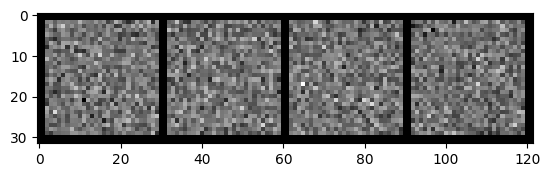

In [ ]:
random = epsilon((4, 1, 28, 28))

display_batch(random)

## Alpha Bar

In the noise process equation, alpha essentially determines **how much to noise
the image** at a particular timestep, t. Lower alpha bar is more noise/less original image

You can modify how alpha bar changes over time to change how quickly the image
gets noisy over time; this is called the **noise schedule**.

In the original diffusion model paper, the researchers used a simple linear
noise schedule. However, the schedule quickly made the image noise up
even before we reached max timesteps.

Instead, of a linear schedule, this code uses a cosine schedule based on
Nichol and Dhariwal's work at OpenAI (https://arxiv.org/abs/2102.09672)

You can see tests between linear vs cosine schedule at
https://hackmd.io/@BaconErie/lin-vs-cos-schedule (might be a bit complicated)

In [ ]:
def alpha_bar(t):
    f_t = cos( ((t/MAX_TIMESTEPS + 0.008)/(1+0.008))  * (pi/2) ) ** 2
    f_0 = cos( ((0.008)/(1+0.008))  * (pi/2) ) ** 2

    return torch.tensor(f_t/f_0)

## Noise function


This is the star of the show, and implements the main noising equation.

Given:

- Batch of images
- Batch of noise
- Timestep t

It will return a batch of noised images that can then be used to train the denoiser model.

In [ ]:
def noise(image, noise, t):
    num_rows = len(image)
    num_cols = len(image[0])

    result = torch.sqrt(alpha_bar(t)) * image + torch.sqrt(1 - alpha_bar(t)) * noise

    return torch.clamp(result, min=-1, max=1)

To demonstrate, here we load a batch of images from the MNIST dataset and then show the images, the noise, and then the noised images at timestep t/T = 0.75

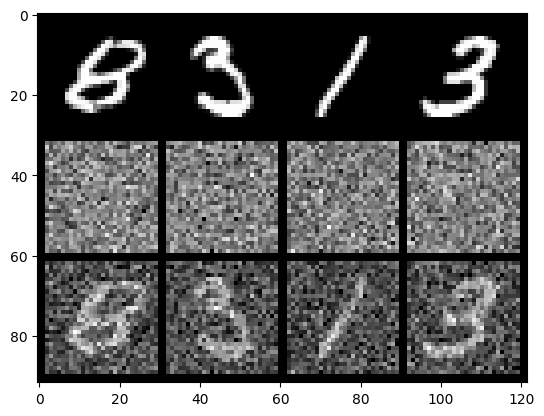

In [ ]:
# First, we will transform the images a bit so that we can work with them

class ScaleToMinusOneToOne(object):
    def __call__(self, tensor):
        return tensor * 2.0 - 1.0

transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL image to tensor
    ScaleToMinusOneToOne()         # Scale tensor values to range from -1 to 1
])

MNIST_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

MNIST_dataloader = torch.utils.data.DataLoader(MNIST_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Then get some images

images, labels = next(iter(MNIST_dataloader))

# Noise them

noise_sample = epsilon(images.shape)
noised_images = noise(images, noise_sample, torch.tensor(0.75 * MAX_TIMESTEPS))


# Take our images, noise, and noised images and put them into a large batch of images, and then display them
display = torch.cat((images, noise_sample, noised_images), dim=0)

display_batch(display, nrow=4, min=-1, max=1)

# Reverse diffusion

Now that we can noise images, it's time to write the code that will turn noise back into images.

We first have a machine learning model predict the noise that's in an image, and then we subtract part of the predicted noise from the noisy image, using the same schedule we used during the forward diffusion/noising process

## Model that predicts noise

This is the model that actually predicts the noise, and is the most important component of the reverse diffusion process.

In the original diffusion model paper, a modified UNet is used, and state-of-the-art diffusion programs such as Stable Diffusion build upon the UNet model and change out specific components in the model.

This notebook, however, will use a more simple model to predict noise. Admittedly, its design is quite arbitrary, but since we are generating small, grayscale images, the model should work decently well, or at least give something that sort of looks like a number.

# # PUT A ARCHITECTURE DIAGRAM EHRE

In [ ]:
# '''
# RES BLOCK

# This bunch of layers will be used later on in the main NoisePredictor model.

# It is an attempt at implementing a residual block that can be found in ResNets.

# The key part of a residual block is adding the input back onto the outputs of the weight layers
# '''
# class ResBlock(nn.Module):
#     def __init__(self, input_channels, output_channels):
#         super(ResBlock, self).__init__()
#         self.convs = nn.Sequential(
#             nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, padding='same'),
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, padding='same'),
#             nn.BatchNorm2d(6)
#         )

#         # Note: Kind of useless if input channels = output channels, adds extra parameters for no reason
#         self.increase_channels = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=1, padding=0, stride=1)

#     def forward(self, x):
#         out = self.convs(x)

#         more_channel_x = self.increase_channels(x)
#         return out + more_channel_x


# '''
# NOISE PREDICTION

# Main model that is used to predict noise
# '''
# class NoisePredictor(nn.Module):
#     def __init__(self):
#         super(NoisePredictor, self).__init__()
#         self.res_block1 = ResBlock(1, 6)
#         self.res_block2 = ResBlock(6, 6)
#         self.res_block3 = ResBlock(6, 6)

#         self.channel_reduction = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1, stride=1, padding=0)


#     def forward(self, x):
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.channel_reduction(x)

#         return torch.tanh(x)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class NoisePredictor(nn.Module):
    def __init__(self):
        super(NoisePredictor, self).__init__()
        self.conv1 = ConvBlock(in_channels=1, out_channels=16)

        self.max_pool1 = nn.MaxPool2d(2)

        # Images should now be 8x14x14

        self.conv2 = ConvBlock(in_channels=16, out_channels=32) # Doubles channel

        self.max_pool2 = nn.MaxPool2d(2) # Halves dimension

        # Images should now be 16x7x7

        self.conv3 = ConvBlock(in_channels=32, out_channels=64)


        # UPSAMPLING AND CONV #
        # Upsample in channels are double the out channels because we concat
        # the outputs from the decoder blocks

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        # 16x14x14
        self.conv4 = ConvBlock(in_channels=64, out_channels=32)


        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # 8x28x28
        self.conv5 = ConvBlock(in_channels=32, out_channels=16)

        # Final 1x1 Conv to reduce channels
        self.channel_reduction = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        conv1_out = self.conv1(x)

        conv2_out = self.conv2(self.max_pool1(conv1_out))
        conv3_out = self.conv3(self.max_pool2(conv2_out))

        conv4_in = torch.cat((self.upconv1(conv3_out), conv2_out), dim=1)
        conv4_out = self.conv4(conv4_in)

        conv5_in = torch.cat((self.upconv2(conv4_out), conv1_out), dim=1)
        conv5_out = self.conv5(conv5_in)

        single_channel = self.channel_reduction(conv5_out)

        return torch.tanh(single_channel)



Let's test the model to make sure the input and output dimensions match.

And, just for fun, let's look at the input images and the output images. Since the model hasn't been trained, all the weights are random, and so the output images are completely useless.

torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])


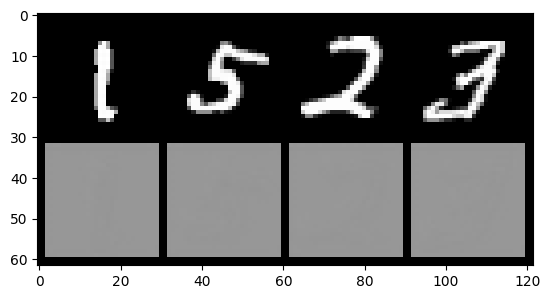

In [ ]:
shape_test = NoisePredictor() # Create a new NoisePredictor model

images, labels = next(iter(MNIST_dataloader)) # We will get some images using the dataloader defined above

output = shape_test(images)

# Print the shapes of the input images and output
# They should match
print(images.shape)
print(output.shape)

display = torch.cat((images, output), dim=0)

display_batch(display, nrow=4, min=-1, max=1)

## Noise remover

# Training

Before we can use the diffusion model, we have to train the noise predictor.

## Getting the data

We will use the MNIST dataset to train our model. We will noise the images later on when we train the model.

In [ ]:
class ScaleToMinusOneToOne(object):
    def __call__(self, tensor):
        return tensor * 2.0 - 1.0

transform = transforms.Compose([
    transforms.ToTensor(),          # Convert PIL image to tensor
    ScaleToMinusOneToOne()         # Scale tensor values to range from -1 to 1
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)




testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

# Create a model instance

In [ ]:
noise_predictor = NoisePredictor()

# Loss function and optimizer

We used MSE loss and stochastic gradient descent to train the model. You can experiment with other loss functions and see how that changes the accuracy of the model.

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(noise_predictor.parameters(), lr=0.001, momentum=0.9)

## Training loop

Finally, here is the code that actually trains the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_predictor.to(device)
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the images
        images, _ = data

        images = images.to(device) # Move to the GPU if GPU is availible

        # Choose a random timestep
        timestep = randint(0, MAX_TIMESTEPS+1)

        # Noise the images, and also save the noise
        sample_noise = epsilon(images.shape).to(device)
        noised_images = noise(images, sample_noise, timestep).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_noise = noise_predictor(noised_images).to(device)
        loss = criterion(predicted_noise, sample_noise).to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Save the model
torch.save(noise_predictor.state_dict(), 'noise_predictor.pt')


[1,  2000] loss: 0.089
[2,  2000] loss: 0.072
[3,  2000] loss: 0.046
[4,  2000] loss: 0.040


Let's test the model!

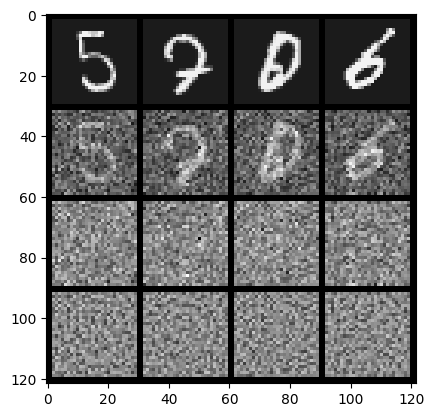

In [ ]:
images, labels = next(iter(MNIST_dataloader))
noise_predictor.to('cpu')
noise_sample = epsilon(images.shape)
noised_images = noise(images, noise_sample, torch.tensor(0.75 * MAX_TIMESTEPS))
predicted_noise = noise_predictor(noised_images)

display = torch.cat((images, noised_images, noise_sample, predicted_noise), dim=0)
display_batch(display, nrow=4)

# Final program